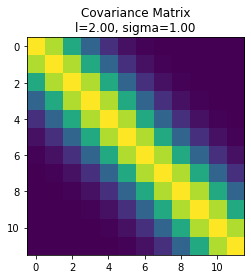

In [ ]:
#@title  { run: "auto", vertical-output: true, form-width: "50%", display-mode: "both" }
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.stats import multivariate_normal

#@title RBF nD-Gaussian Conditioning
def get_cond_predictions(cov, cond_labels, cond_inds, size=1, noise=0.1):
  '''
  Generates samples from gaussian distribution defined by 0 mean and 
  cov as the covariance matrix, and conditioned on variables defined by 
  cond_labels, cond_inds.

  Args:
      cov:         Covariance Matrix, numpy array (n x n)
      cond_labels: Values of data points that are known, float list [m]
      cond_inds:   Indices of dimensions with known data points, int list [m]
      size:        Number of data points to sample from conditional

  Returns:
      Samples generated from the distribution
  '''
  # get indices of unconitioned dimensions, int list [n-m]
  not_cond_inds = np.delete(np.arange(len(cov)), cond_inds)

  # partition covariance matrix in AA, AB and BB
  AA = cov[not_cond_inds][:, not_cond_inds]
  AB = cov[not_cond_inds][:, cond_inds]
  BB = cov[cond_inds][:, cond_inds]

  # marganilize conditioned variables
  BB_inv = np.linalg.inv(BB)
  cond_cov = AA-AB@BB_inv@AB.T
  cond_mean = AB@BB_inv@np.array(cond_labels).T

  preds = np.random.multivariate_normal(cond_mean, 
                                        cond_cov, 
                                        size)

  cond_labels = np.random.normal(scale=noise, size=(size, len(cond_labels))) + \
                np.array(cond_labels).reshape(1, -1)

  # pack conditioned and predictions into a single tensor
  data = np.ones((size, len(cov)))
  data[:, cond_inds] *= cond_labels
  data[:, not_cond_inds] = preds
  return data

def kernel(X1, X2, l=1.0, sigma_f=1.0):
  '''
  Isotropic squared exponential kernel. Computes 
  a covariance matrix from points in X1 and X2.
  It is also known as radial basis function (RBF).

  Args:
      X1: Array of m points (m x d).
      X2: Array of n points (n x d).

  Returns:
      Covariance matrix (m x n).
  
  http://krasserm.github.io/2018/03/19/gaussian-processes/
  '''
  sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
  return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def animate(i):
  x = np.arange(uncond_preds.shape[1])+1
  y = uncond_preds[i]
  line.set_data(x, y)
  line1.set_data(x, y)
  return (line,)

#@title { run: "auto", vertical-output: true, form-width: "50%", display-mode: "form" }

#@markdown Number of dimensions in the Gaussian Distribution
gaussian_dim = 12 #@param {type:"slider", min:2, max:100, step:1}

#@markdown Kernel function parameter <b>𝑙</b>
kernel_l = 2 #@param {type:"slider", min:1, max:10, step:1}

#@markdown Kernel function parameter <b>σ</b>
kernel_sigma = 1 #@param {type:"slider", min:1, max:10, step:1}

#@markdown Indices of dimensions for which we know the y value. Comma separated list of floats (Has to be grater than 0 and less than gaussian_dim)
cond_inds = "1, 5, 10" #@param {type:"string"}
#@markdown y values of cond_inds
cond_labels = "1, 0.2, 0.5" #@param {type:"string"}
#@markdown sigma of gaussian noise(0 mean) added to known data points 
cond_noise = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

# Known dimension values to condition on
cond_labels = np.array([float(i) for i in cond_labels.split(',')])
cond_inds = np.array([int(i) for i in cond_inds.split(',')])

# Generate Covariance matrix
x = np.arange(gaussian_dim).reshape(-1, 1)
cov = kernel(x, x, l=float(kernel_l), sigma_f=float(kernel_sigma))

# Generate data
uncond_preds = get_cond_predictions(cov, 
                                    cond_labels=cond_labels, 
                                    cond_inds=cond_inds-1, 
                                    size=20,
                                    noise=cond_noise)


## Plot covariance and sampled data
plt.imshow(cov)
plt.title('Covariance Matrix\nl={:.2f}, sigma={:.2f}'.format(kernel_l, 
                                                             kernel_sigma))
plt.show()

fig, ax = plt.subplots()
plt.close()
ax.set_xlim((0.8, len(cov)+0.2))
ax.set_ylim((-4, 4))
ax.set_xlabel("Variable Index")
ax.set_ylabel("y")
line, = ax.plot([], [], 
                color='C0', 
                marker='o', 
                markerfacecolor='C0')
line1, = ax.plot([], [], 
                 marker='o', 
                 markerfacecolor='C1', 
                 markevery=list(cond_inds-1))

animation.FuncAnimation(fig, animate, 
                        init_func=(line.set_data([], [])),
                        frames=len(uncond_preds))